In [1]:
import numpy as np
import ufl
from dolfinx.fem import Function, form, assemble_matrix
from dolfinx.fem.petsc import create_vector, create_matrix, assemble_vector, assemble_matrix

from pybandgap_opt.set_structure import SetStructure, Material
from pybandgap_opt.fem import FemUtils
from pybandgap.bandgap import bandgap
from meshes.truss_like_mesh import truss_like_cross

np.set_printoptions(precision=3, suppress=False, formatter={'float': '{:0.1e}'.format})

meshes,*_ = truss_like_cross()

In [2]:
A1 = np.pi*4e-6
A2 = np.pi*16e-6

In [3]:
aluminum = Material('aluminum', young_modulus=70e9, poisson_ratio=0.33, density=2.7e3)
tungsten = Material('tungsten', young_modulus=411e9, poisson_ratio=0.28, density=19.3e3)

In [4]:
structure = SetStructure(meshes = meshes)
elements_IBZ, condition_IBZ= structure.find_irreducible_brillouin_zone()

In [5]:
tungsten_elements = [1, 2, 4, 8]
max_diameter_elements = np.append(tungsten_elements, 13)

In [6]:
material_elements = np.array([
    1 if i in tungsten_elements else 0
    for i in elements_IBZ])

diameters_elements = np.array([
    1 if i in max_diameter_elements else 0
    for i in elements_IBZ])

In [7]:
structure.set_prop('materials', material_elements)
structure.set_prop('diameters', diameters_elements)

In [8]:
fem = FemUtils(structure)

In [9]:
def M_ufl(u, v, A, rho):
    return A*rho*ufl.inner(u, v) * ufl.dx

In [10]:
def M_form(fem):
    V = fem.V
    V0 = fem.V0
    x_A = Function(V0)
    x_rho = Function(V0)

    x_A.x.array[:] = fem.structure.props[0].diameters
    x_rho.x.array[:] = fem.structure.props[0].materials

    # Define material interpolations
    A = (A2 - A1)*x_A + A1
    rho = (tungsten.density - aluminum.density)*x_rho + aluminum.density

    u = fem.u
    v = fem.v

    # Bilinear form with proper conjugation for complex forms
    M = M_ufl(u, v, A, rho)  # Add conjugation to test function

    return form(M)

form_M =  M_form(fem)

In [11]:
def K_form(fem):
    V0 = fem.V0
    
    # Definir coeficientes UFL para las variables de control
    x_A = ufl.Coefficient(V0)
    x_E = ufl.Coefficient(V0)
    
    # Crear funciones para evaluar
    x_A_func = Function(V0)
    x_E_func = Function(V0)
    
    # Asignar valores a las funciones de control
    x_A_func.x.array[:] = fem.structure.props[0].diameters
    x_E_func.x.array[:] = fem.structure.props[0].materials

    # Definir las interpolaciones de material
    A = (A2 - A1)*x_A + A1
    E = (tungsten.young_modulus - aluminum.young_modulus)*x_E + aluminum.young_modulus

    u = fem.u
    v = fem.v

    epsilon = lambda u: ufl.sym(ufl.grad(u))
    sigma = lambda u: ufl.tr(epsilon(u)) * ufl.Identity(len(u))

    # Forma bilineal parametrizada
    K_ufl = ufl.inner(E * A * sigma(u), epsilon(v)) * ufl.dx
    
    # Forma principal
    K_form = form(ufl.replace(K_ufl, {x_A: x_A_func, x_E: x_E_func}))
    
    # Derivadas completas
    dK_dx_A = ufl.diff(K_ufl, x_A)
    dK_dx_A_form = form(ufl.replace(dK_dx_A, {x_A: x_A_func, x_E: x_E_func}))

    dK_dx_E = ufl.diff(K_ufl, x_E)
    dK_dx_E_form = form(ufl.replace(dK_dx_E, {x_A: x_A_func, x_E: x_E_func}))

    # Print derivative with respect to x_A_1
    # Create a test function that's 1 at node 1 and 0 elsewhere
    test_func = Function(V0)
    test_func.x.array[0] = 1.0
    
    t_K_ufl = ufl.inner(test_func * E * A * sigma(u), epsilon(v)) * ufl.dx
    
    t_dK_dx_A = ufl.diff(t_K_ufl, x_A)
    t_dK_dx_A_form = form(ufl.replace(t_dK_dx_A, {x_A: x_A_func, x_E: x_E_func}))
    
    # Evaluate the derivative form at this test function
    first_derivative_matrix = fem.assemble_global_matrix(t_dK_dx_A_form)
    print("Derivative matrix for first element of x_A:")
    print(np.real(first_derivative_matrix.getValues(range(4), range(4))))

    return K_form, dK_dx_A_form, dK_dx_E_form

form_K, dK_dx_A_form, dK_dx_E_form =  K_form(fem)

Derivative matrix for first element of x_A:
[[6.2e+08 0.0e+00 -6.2e+08 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [-6.2e+08 0.0e+00 6.2e+08 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00]]


In [12]:
M= fem.assemble_global_matrix(M_form(fem))
K= fem.assemble_global_matrix(form_K)

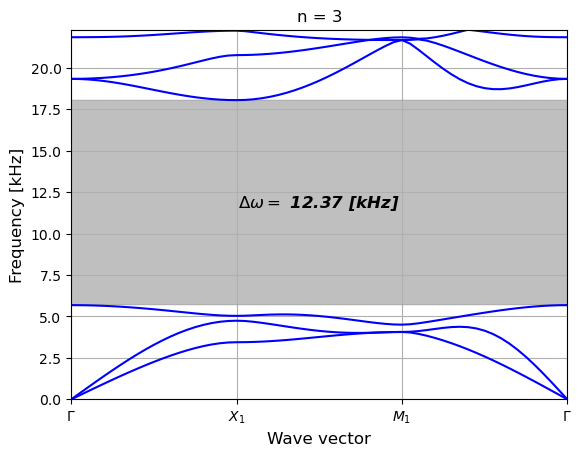

In [13]:
_ = bandgap(3, structure, M, K, N_eig = 6, plot= True, NINT=60, tol = 1e-15, max_it = 200)